# 15.077 Final Project - Predicting running performance using personal data
# Performance prediction

In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, expon
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")
np.random.seed(0)

In [ ]:
# Load training data
data_train = pd.read_csv("data_train_dup.csv", index_col = 0)
X_train = data_train.iloc[:,1:].values
y_train = data_train.iloc[:,0].values.reshape(-1,1)

In [ ]:
# Load test data
data_test = pd.read_csv("data_test.csv", index_col = 0)
X_test = data_test.iloc[:,1:].values
y_test = data_test.iloc[:,0].values.reshape(-1,1)

In [ ]:
# Create absolute percentage error function
def ape(y_true, y_pred):
    return [np.abs((y_true[i]-y_pred[i])/y_true[i]) for i in range(len(y_pred))]

## Random forest

In [ ]:
# Fit random forest on training data
reg = RandomForestRegressor()
reg.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
# Prediction on test set
y_pred_rf = reg.predict(X_test)

In [ ]:
# Prediction performance
ape_rf = ape(y_test, y_pred_rf)
res_rf = np.mean(ape_rf), np.median(ape_rf)
print("MAPE (Random Forest) = " + str(round(res_rf[0]*100, 2)) + "%")
print("MedAPE (Random Forest) = " + str(round(res_rf[1]*100, 2)) + "%")

MAPE (Random Forest) = 4.3%
MedAPE (Random Forest) = 2.83%


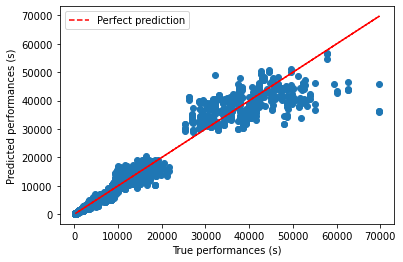

In [ ]:
# Plot
plt.scatter(y_test, y_pred_rf)
plt.plot(y_test, y_test, color = "r", linestyle = "dashed", label = "Perfect prediction")
#plt.title("Predicted vs. True performances - Random forest")
plt.xlabel("True performances (s)")
plt.ylabel("Predicted performances (s)")
plt.legend()
plt.show()

## FFA scale

In [ ]:
# Load FFA scales
scale_F = pd.read_csv("ffa_scale_F.csv", sep = ";")
scale_M = pd.read_csv("ffa_scale_M.csv", sep = ";")
scale_F.columns = ["Level", 0.8, 1, 1.5, 3, 5, 10, 15, 21.097, 42.195, 100]
scale_M.columns = ["Level", 0.8, 1, 1.5, 3, 5, 10, 15, 21.097, 42.195, 100]

In [ ]:
# Prediction on test set
y_pred_ffa = []

for i in range(data_test.shape[0]):
  perf_dist = data_test.iloc[i,:].PerfDist
  perf_time = data_test.iloc[i,:].PerfTime
  pred_dist = data_test.iloc[i,:].PredDist
  gender = data_test.iloc[i,:].Gender

  if gender == 1:
    scale = scale_M[perf_dist].values
    index_perf = sum(perf_time > scale)
   
    if index_perf == 0:
      y_pred_ffa.append(scale_M[pred_dist].values[0])
    elif index_perf == len(scale)-1:
      y_pred_ffa.append(scale_M[pred_dist].values[-1])
    else:
      adj = (perf_time - scale_M[perf_dist].values[index_perf-1]) / scale_M[perf_dist].values[index_perf-1]
      y_pred_ffa.append(scale_M[pred_dist].values[index_perf-1]*(1+adj))

  else:
    scale = scale_F[perf_dist].values
    index_perf = sum(perf_time > scale)
    
    if index_perf == 0:
      y_pred_ffa.append(scale_F[pred_dist].values[0])
    elif index_perf == len(scale)-1:
      y_pred_ffa.append(scale_F[pred_dist].values[-1])
    else:
      adj = (perf_time - scale_F[perf_dist].values[index_perf-1]) / scale_F[perf_dist].values[index_perf-1]
      y_pred_ffa.append(scale_F[pred_dist].values[index_perf-1]*(1+adj))

In [ ]:
# FFA scale prediction performance
ape_ffa = ape(y_test, y_pred_ffa)
res_ffa = np.mean(ape_ffa), np.median(ape_ffa)
print("MAPE (French Athletics Federation Scale) = " + str(round(res_ffa[0]*100, 2)) + "%")
print("MedAPE (French Athletics Federation Scale) = " + str(round(res_ffa[1]*100, 2)) + "%")

MAPE (French Athletics Federation Scale) = 7.55%
MedAPE (French Athletics Federation Scale) = 3.9%


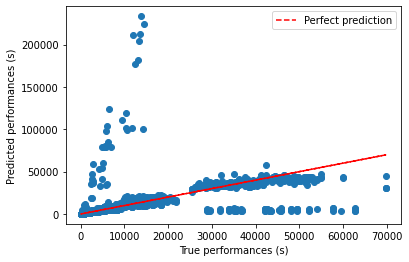

In [ ]:
# Plot
plt.scatter(y_test, y_pred_ffa)
plt.plot(y_test, y_test, color = "r", linestyle = "dashed", label = "Perfect prediction")
#plt.title("Predicted vs. True performances - FFA scale")
plt.xlabel("True performances (s)")
plt.ylabel("Predicted performances (s)")
plt.legend()
plt.show()

## Concatenate training and test data sets for new predictions

In [ ]:
# Concatenate training and test data sets
data_train = pd.read_csv("data_train.csv", index_col = 0)
data_full = pd.concat([data_train, data_test], axis = 0)

In [ ]:
# Remove outliers from full data set (see data analysis part)
# Store index in first column
data_full.insert(0, "Index", data_full.index)
data_full = data_full.reset_index(drop = True)

# y outliers
pred_dist = np.sort(data_full.PredDist.unique())
genders = [0,1]

for dist in pred_dist:
  for gender in genders:
    df = data_full[(data_full.PredDist == dist) & (data_full.Gender == gender)]
    scores = norm.cdf(np.log(df.y), loc = np.mean(np.log(df.y)), scale = np.std(np.log(df.y)))
    filt = np.abs(scores - 0.5) >= 0.999/2
    data_full = data_full.iloc[~data_full.index.isin(df.iloc[filt,:].index),:]

# PerfTime outliers
perf_dist = np.sort(data_full.PerfDist.unique())

for dist in perf_dist:
  for gender in genders:
    df = data_full[(data_full.PerfDist == dist) & (data_full.Gender == gender)]
    scores = norm.cdf(np.log(df.PerfTime), loc = np.mean(np.log(df.PerfTime)), scale = np.std(np.log(df.PerfTime)))
    filt = np.abs(scores - 0.5) >= 0.999/2
    data_full = data_full.iloc[~data_full.index.isin(df.iloc[filt,:].index),:]

# AgePred outliers
scores = norm.cdf(data_full.AgePred, loc = np.mean(data_full.AgePred), scale = np.std(data_full.AgePred))
filt = np.abs(scores - 0.5) >= 0.999/2
data_full = data_full.iloc[~filt,:]

# DeltaAgePerf outliers
scores = expon.cdf(data_full.DeltaAgePerf, scale = np.mean(data_full.DeltaAgePerf))
filt = (scores >= 0.999) | (data_full.DeltaAgePerf.values < 0)
data_full = data_full.iloc[~filt,:]

# Height outliers
for gender in genders:
  df = data_full[data_full.Gender == gender]
  scores = norm.cdf(df.Height, loc = np.mean(df.Height), scale = np.std(df.Height))
  filt = np.abs(scores - 0.5) >= 0.999/2
  data_full = data_full.iloc[~data_full.index.isin(df.iloc[filt,:].index),:]

# Weight outliers
for gender in genders:
  df = data_full[data_full.Gender == gender]
  scores = norm.cdf(df.Weight, loc = np.mean(df.Weight), scale = np.std(df.Weight))
  filt = np.abs(scores - 0.5) >= 0.999/2
  data_full = data_full.iloc[~data_full.index.isin(df.iloc[filt,:].index),:]

# Alpha outliers
df = data_full[data_full.Alpha > 0]
scores = norm.cdf(df.Alpha, loc = np.mean(df.Alpha), scale = np.std(df.Alpha))
filt = np.abs(scores - 0.5) >= 0.999/2
data_full = data_full.iloc[~data_full.index.isin(df.iloc[filt,:].index),:]

# Beta outliers
df = data_full[data_full.Beta > 0]
scores = norm.cdf(df.Beta, loc = np.mean(df.Beta), scale = np.std(df.Beta))
filt = np.abs(scores - 0.5) >= 0.999/2
data_full = data_full.iloc[~data_full.index.isin(df.iloc[filt,:].index),:]

# Set index back in place
data_full = data_full.set_index("Index")

In [ ]:
# In order to enable accurate prediction when alpha and beta are not available create duplicate rows where Alpha = Beta = IsAlphaBeta = 0
df_dup = data_full[data_full.IsAlphaBeta == 1]
df_dup[["Alpha", "Beta", "IsAlphaBeta"]] = 0
data_full = pd.concat([data_full, df_dup], axis = 0)
data_full = data_full.loc[data_full.index.unique(),:]

## Fit random forest on full data set

In [ ]:
# Fit model
X = data_full.iloc[:,1:].values
y = data_full.iloc[:,0].values.reshape(-1,1)
reg = RandomForestRegressor()
reg.fit(X,y)

RandomForestRegressor()

In [ ]:
# Store regressor for new predictions
f = open("rf_regressor.pckl", "wb")
pickle.dump(reg, f)
f.close()